# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE): 
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$ 
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

In [7]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print(f"Device = {device}, dtype = {dtype}")

Device = cuda, dtype = torch.float32


### Dataset

In [8]:
with h5py.File("EffectiveConductivity.h5", "r") as data:
    print(data.keys())
    # Training data
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    # Testing data
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # Coordinates
    X = torch.tensor(np.array(data["X"]), dtype=dtype)
    Y = torch.tensor(np.array(data["Y"]), dtype=dtype)

# Get the number of training and testing samples and the grid resolution
ntrain = k_train.shape[0]
ntest = k_test.shape[0]
res = k_train.shape[-1]

# Mesh grid for the coordinates
mesh = np.vstack([X.ravel(), Y.ravel()]).T
gridx = mesh.reshape(1, res, res, 2)
x_train = torch.tensor(gridx, dtype=dtype).repeat(ntrain, 1, 1, 1)

# Add dimensions for compatibility with FNO
k_train, T_train = k_train.unsqueeze(-1), T_train.unsqueeze(-1)
k_test, T_test = k_test.unsqueeze(-1), T_test.unsqueeze(-1)
kx_train = torch.cat((k_train, x_train), dim=-1)

print("\nTraining data...")
print("x_train shape:", x_train.shape)
print("k_train shape:", k_train.shape)
print("T_train shape:", T_train.shape)
print("kx_train shape:", kx_train.shape)

print("\nTesting data...")
print("k_test shape:", k_test.shape)
print("T_test shape:", T_test.shape)

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>

Training data...
x_train shape: torch.Size([1000, 36, 36, 2])
k_train shape: torch.Size([1000, 36, 36, 1])
T_train shape: torch.Size([1000, 36, 36, 1])
kx_train shape: torch.Size([1000, 36, 36, 3])

Testing data...
k_test shape: torch.Size([200, 36, 36, 1])
T_test shape: torch.Size([200, 36, 36, 1])


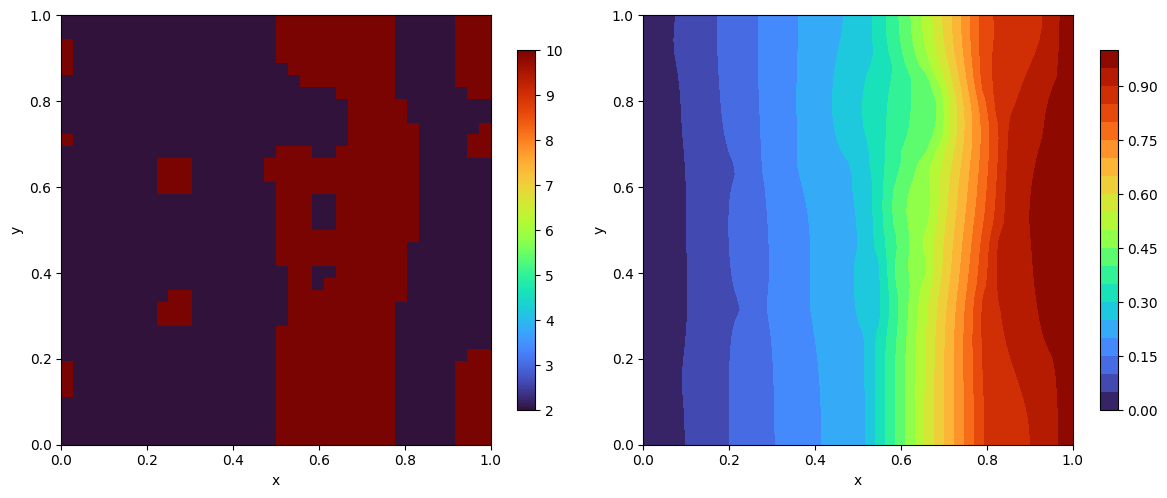

In [9]:
k_show, u_show = k_train[0], T_train[0]

mesh = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
x_plot, y_plot = mesh[0], mesh[1]

fix, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot conductivity field (piecewise constant, thus no interpolation)
im1 = axs[0].imshow(k_show.squeeze(), cmap='turbo', origin='lower', extent=[0, 1, 0, 1], interpolation='nearest')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_aspect("equal")
plt.colorbar(im1, ax=axs[0], shrink=0.8)

# Plot temperature field
im2 = axs[1].contourf(x_plot, y_plot, u_show.squeeze(), levels=20, cmap='turbo')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_aspect("equal")
plt.colorbar(im2, ax=axs[1], shrink=0.8)

plt.tight_layout()
plt.show()

## Neural Network Architecture for FNO

In [10]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    """Spectral convolution layer."""

    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()

        # Input and output size
        self.in_size = in_size
        self.out_size = out_size
        # Modes in x and y direction
        self.modes1 = modes1
        self.modes2 = modes2

        # Scale factor for initializing
        self.scale = 1./(in_size * out_size)

        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64
        elif dtype==torch.float64:
            ctype = torch.complex128
        else:
            raise ValueError("Unsupported dtype. Use torch.float32 or torch.float64.")

        # Learnable weights for the Fourier modes
        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))

    def compl_mul_2d(self, input, weights):
        """Complex multiplication of two tensors in the Fourier domain."""
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        """Forward pass through the spectral convolution layer."""
        # Store batch size
        batch_size = x.shape[0]

        # Fast Fourier Transform (FFT) of the input
        # x_ft: size(batch_size, in_size, height, width//2+1)
        x_ft = torch.fft.rfft2(x)

        # Create an output tensor for the Fourier domain result
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1,
                             device=x.device, dtype=torch.cfloat)
        # Multiply the low-frequency modes
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        # Multiply the high-frequency modes
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)

        # Return to physical space using Inverse Fast Fourier Transform (IFFT)
        # x: size(batch_size, out_size, height, width)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

        return x

class FNO2d(nn.Module):
    """Fourier Neural Operator (FNO) architecture for 2D problems."""

    def __init__(self, in_size, out_size, modes1, modes2, hidden_list, dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list
        self.activation = nn.ReLU()

        # Input lifting layer: maps input features to the hidden dimension
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)

        # Hidden layers consisting of spectral convolutions and linear transformations
        conv_net, w_net = [], []
        hidden_in = hidden_list[0]
        for hidden_out in hidden_list:
            # Spectral convolution layer
            conv_net.append(SpectralConv2d(hidden_in, hidden_out, modes1, modes2, dtype))
            # Linear transformation applied to each spatial point (1x1 convolution)
            w_net.append(nn.Conv1d(hidden_in, hidden_out, 1, dtype=dtype))
            hidden_in =  hidden_out
        # Store both sequences of layers
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)

        # Output layers
        self.fc_out0 = nn.Linear(hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)

    def forward(self, ax):
        """Forward pass through the FNO model."""
        batch_size = ax.shape[0]
        mx_size, my_size = ax.shape[1], ax.shape[2]

        # Input lifting: apply the linear layer and change tensor dimensions
        ax = self.fc_in(ax)
        ax = ax.permute(0, 3, 1, 2)

        # Apply spectral convolution and weight network layers
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            # Apply spectral convolution
            ax1 = conv(ax)
            # Apply weight network (linear transformation per point)
            ax2 = weight(ax.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            # Combine results and apply activation
            ax = self.activation(ax1 + ax2)

        # Change dimensions to (batch_size, height, width, channels)
        ax = ax.permute(0, 2, 3, 1)

        # Output layer: change dimensions back and apply linear layers
        ax = self.fc_out0(ax)
        ax = self.activation(ax)

        # Final output layer without activation
        x = self.fc_out1(ax)

        return x

mode1, mode2 = 8, 8
hidden_list = [40, 40, 40]
model_u = FNO2d(kx_train.shape[-1], T_train.shape[-1], mode1, mode2, hidden_list).to(device)

total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

624,857 training parameters.


### Loss and Error

In [11]:
class LossClass(object):
    """Loss between predicted and true temperature fields."""

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model

    def __call__(self, ax_batch, u_batch):
        batch_size = ax_batch.shape[0]
        ax, u = ax_batch.to(self.device), u_batch.to(self.device)

        u_pred = self.u_model(ax)
        loss = torch.norm(u.reshape(batch_size, -1) - u_pred.reshape(batch_size, -1), 2, 1)

        return torch.mean(loss)

class ErrorClass(object):
    """Relative L2 error between predicted and true temperature fields."""
    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model

    def __call__(self, ax_batch, u_batch):
        ax, u = ax_batch.to(self.device), u_batch.to(self.device)
        u_pred = self.u_model(ax)

        return torch.norm(u - u_pred) / torch.norm(u)

## Dataloader Function

In [12]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, ax, u):
        self.ax = ax
        self.u = u

    def __len__(self):
        return self.ax.shape[0]

    def __getitem__(self, idx):
        ax = self.ax[idx]
        u = self.u[idx]
        return ax, u

train_loader = DataLoader(MyDataset(kx_train, T_train), batch_size=50, shuffle=True)
for kx_batch, T_batch in train_loader:
    print("kx_batch shape:", kx_batch.shape, "T_batch shape:", T_batch.shape)

kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3])

### Training

In [13]:
from tqdm import trange
import time

epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_class = LossClass(model_u)
error_class = ErrorClass(model_u)

start_time = time.time()

loss_history, error_history = [], []
for epoch in trange(epochs):
    loss = 0.
    l2_error = 0.

    for ax_batch, T_batch in train_loader:
        loss_train = loss_class(ax_batch, T_batch)

        # Optimization step
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss += loss_train

        # Calculate L2 relative error for the batch
        l2_error += error_class(ax_batch, T_batch)

    scheduler.step()

    # Calculate average over batches
    loss = loss / len(train_loader)
    l2_error = l2_error / len(train_loader)
    # Add them to the loss and error history
    loss_history.append(loss.item())
    error_history.append(l2_error.item())

    if (epoch+1) % 100 == 0:
        print(f" Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, L2 Relative Error: {l2_error.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal simulation time: {total_time:.2f} seconds")

  5%|▌         | 100/2000 [00:50<15:27,  2.05it/s]

 Epoch 100/2000, Loss: 0.1703, L2 Relative Error: 0.0082, Learning Rate: 0.001000


 10%|█         | 200/2000 [01:39<14:44,  2.03it/s]

 Epoch 200/2000, Loss: 0.1565, L2 Relative Error: 0.0079, Learning Rate: 0.001000


 15%|█▌        | 300/2000 [02:28<13:52,  2.04it/s]

 Epoch 300/2000, Loss: 0.1396, L2 Relative Error: 0.0066, Learning Rate: 0.001000


 20%|██        | 400/2000 [03:16<13:02,  2.04it/s]

 Epoch 400/2000, Loss: 0.1102, L2 Relative Error: 0.0054, Learning Rate: 0.001000


 25%|██▌       | 500/2000 [04:05<12:11,  2.05it/s]

 Epoch 500/2000, Loss: 0.1568, L2 Relative Error: 0.0074, Learning Rate: 0.000500


 30%|███       | 600/2000 [04:54<11:23,  2.05it/s]

 Epoch 600/2000, Loss: 0.0651, L2 Relative Error: 0.0031, Learning Rate: 0.000500


 35%|███▌      | 700/2000 [05:43<10:33,  2.05it/s]

 Epoch 700/2000, Loss: 0.0641, L2 Relative Error: 0.0031, Learning Rate: 0.000500


 40%|████      | 800/2000 [06:32<09:44,  2.05it/s]

 Epoch 800/2000, Loss: 0.0603, L2 Relative Error: 0.0029, Learning Rate: 0.000500


 45%|████▌     | 900/2000 [07:21<08:55,  2.05it/s]

 Epoch 900/2000, Loss: 0.0620, L2 Relative Error: 0.0030, Learning Rate: 0.000500


 50%|█████     | 1000/2000 [08:09<08:07,  2.05it/s]

 Epoch 1000/2000, Loss: 0.0567, L2 Relative Error: 0.0027, Learning Rate: 0.000250


 55%|█████▌    | 1100/2000 [08:58<07:18,  2.05it/s]

 Epoch 1100/2000, Loss: 0.0482, L2 Relative Error: 0.0023, Learning Rate: 0.000250


 60%|██████    | 1200/2000 [09:49<06:29,  2.06it/s]

 Epoch 1200/2000, Loss: 0.0437, L2 Relative Error: 0.0021, Learning Rate: 0.000250


 65%|██████▌   | 1300/2000 [10:39<05:42,  2.04it/s]

 Epoch 1300/2000, Loss: 0.0441, L2 Relative Error: 0.0021, Learning Rate: 0.000250


 70%|███████   | 1400/2000 [11:27<04:51,  2.06it/s]

 Epoch 1400/2000, Loss: 0.0425, L2 Relative Error: 0.0020, Learning Rate: 0.000250


 75%|███████▌  | 1500/2000 [12:16<04:02,  2.06it/s]

 Epoch 1500/2000, Loss: 0.0435, L2 Relative Error: 0.0021, Learning Rate: 0.000125


 80%|████████  | 1600/2000 [13:05<03:14,  2.06it/s]

 Epoch 1600/2000, Loss: 0.0412, L2 Relative Error: 0.0020, Learning Rate: 0.000125


 85%|████████▌ | 1700/2000 [13:54<02:25,  2.06it/s]

 Epoch 1700/2000, Loss: 0.0375, L2 Relative Error: 0.0018, Learning Rate: 0.000125


 90%|█████████ | 1800/2000 [14:43<01:37,  2.05it/s]

 Epoch 1800/2000, Loss: 0.0370, L2 Relative Error: 0.0018, Learning Rate: 0.000125


 95%|█████████▌| 1900/2000 [15:31<00:48,  2.05it/s]

 Epoch 1900/2000, Loss: 0.0376, L2 Relative Error: 0.0018, Learning Rate: 0.000125


100%|██████████| 2000/2000 [16:20<00:00,  2.04it/s]

 Epoch 2000/2000, Loss: 0.0363, L2 Relative Error: 0.0017, Learning Rate: 0.000063

Total simulation time: 980.73 seconds


### Results

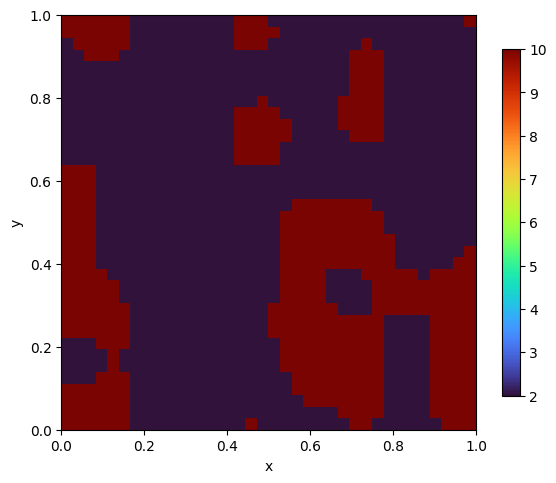

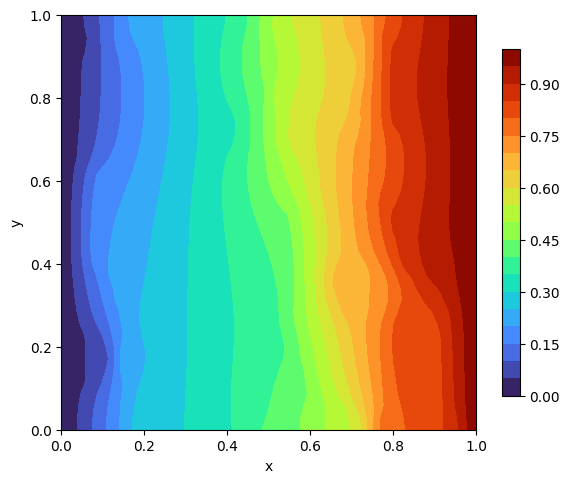

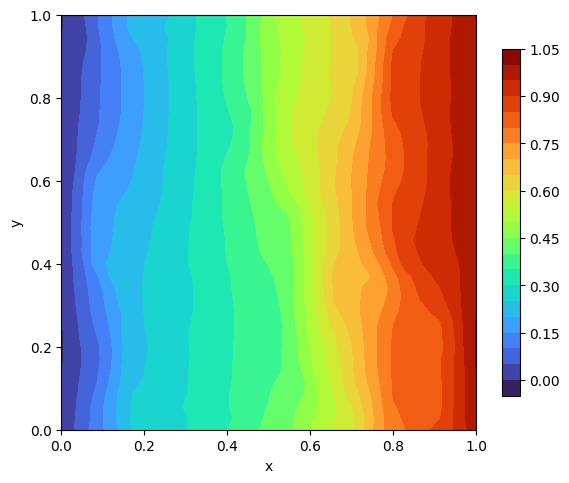

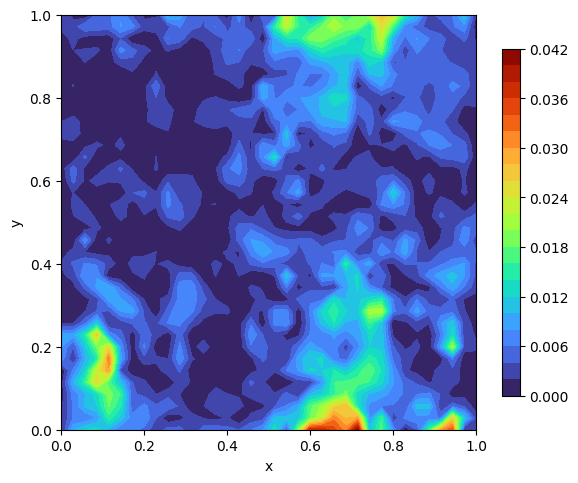

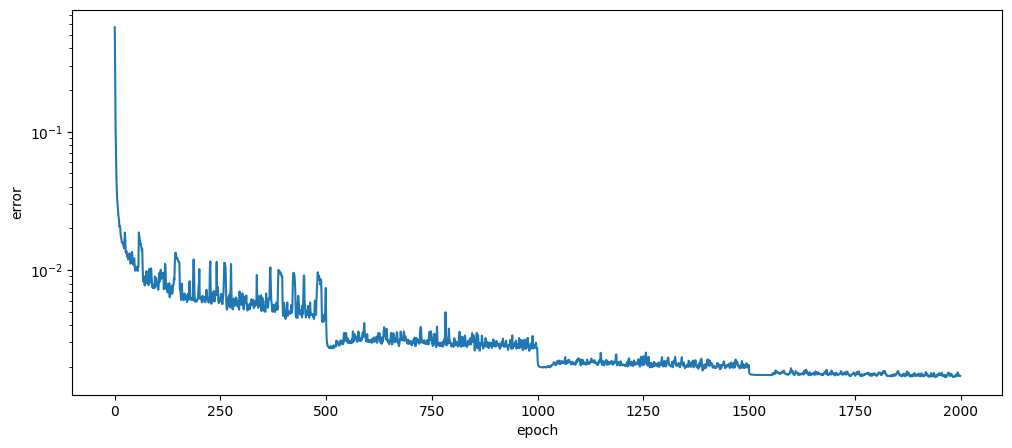

In [22]:
# Plots for the first test sample

# Get first sample
kx = torch.cat((k_test[0].unsqueeze(0), torch.tensor(gridx, dtype=dtype).repeat(1, 1, 1, 1)), dim=-1).to(device)
T_true = T_test[0].unsqueeze(0).to(device)

# Pass through the trained NN
T_pred = model_u(kx)

with torch.no_grad():
  # Back to cpu fix dimensions
  k_plot = kx[0, ..., 0].cpu().squeeze().numpy()
  T_true_plot = T_true[0].cpu().squeeze().numpy()
  T_pred_plot = T_pred[0].cpu().squeeze().numpy()
  error_plot = np.abs(T_true_plot - T_pred_plot)

  # Plot conductivity field (piecewise constant, thus no interpolation)
  fig1, axs1 = plt.subplots(1, 1, figsize=(6, 5))
  im1 = axs1.imshow(k_plot, cmap="turbo", origin="lower", extent=[0, 1, 0, 1], interpolation="nearest")
  axs1.set_xlabel("x")
  axs1.set_ylabel("y")
  axs1.set_aspect("equal")
  plt.colorbar(im1, ax=axs1, shrink=0.8)
  plt.tight_layout()
  plt.savefig("task3_conductivity.pdf")
  plt.show()


  # Plot true temperature field
  fig2, axs2 = plt.subplots(1, 1, figsize=(6, 5))
  im2 = axs2.contourf(x_plot, y_plot, T_true_plot, levels=20, cmap="turbo")
  axs2.set_xlabel("x")
  axs2.set_ylabel("y")
  axs2.set_aspect("equal")
  plt.colorbar(im2, ax=axs2, shrink=0.8)
  plt.tight_layout()
  plt.savefig("task3_true.pdf")
  plt.show()


  # Plot predicted temperature field
  fig3, axs3 = plt.subplots(1, 1, figsize=(6, 5))
  im3 = axs3.contourf(x_plot, y_plot, T_pred_plot, levels=20, cmap="turbo")
  axs3.set_xlabel("x")
  axs3.set_ylabel("y")
  axs3.set_aspect("equal")
  plt.colorbar(im3, ax=axs3, shrink=0.8)
  plt.tight_layout()
  plt.savefig("task3_pred.pdf")
  plt.show()


  # Plot absolute error
  fig4, axs4 = plt.subplots(1, 1, figsize=(6, 5))
  im4 = axs4.contourf(x_plot, y_plot, error_plot, levels=20, cmap="turbo")
  axs4.set_xlabel("x")
  axs4.set_ylabel("y")
  axs4.set_aspect("equal")
  plt.colorbar(im4, ax=axs4, shrink=0.8)
  plt.tight_layout()
  plt.savefig("task3_error.pdf")
  plt.show()

  # Plot error vs epoch
plt.figure(figsize=(12, 5))
plt.semilogy(error_history)
plt.xlabel("epoch")
plt.ylabel("error")
plt.savefig("task3_error_vs_epoch.pdf")
plt.show()
